<a href="https://colab.research.google.com/github/SuvarshaChennareddy/Zeotap-Data-Science-Assignment/blob/main/Suvarsha_Chennareddy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read the data
customers_df = pd.read_csv('/content/drive/MyDrive/Zeotap/Customers.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Zeotap/Products.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/Zeotap/Transactions.csv')

In [69]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [70]:
products_df.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [71]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


The lookalike model I've created uses the following features to determine similarity:

1. Region (encoded)
2. Purchase behavior across different product categories
3. Average transaction value

The model works by:

1. Creating user profiles that combine demographic and transaction data
2. Applying mean-centering to normalize the features
3. Computing cosine similarity between the centered features
4. Identifying the top 3 most similar customers for each target customer

The similarity scores range from -1 to 1, where:
- 1 indicates perfect similarity
- 0 indicates no similarity
- -1 indicates perfect dissimilarity

The output CSV file (Lookalike.csv) contains:
- CustomerID: The target customer
- Lookalikes: Three most similar customers with their similarity scores in format "CustomerID:score"

Would you like me to modify any aspect of the model or explain any part in more detail?

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Read and prepare the data
def prepare_data(customers_df, products_df, transactions_df):

    # One-hot encode 'Region' column
    region_encoded = pd.get_dummies(customers_df['Region'], prefix='Region')
    customers_df = pd.concat([customers_df, region_encoded], axis=1)
    print("Customers with region one hot encoded: ")
    print(customers_df.head())
    print("\n")

    # Create user profiles based on transaction history
    # Get product categories for each transaction
    transactions_with_category = pd.merge(
        transactions_df,
        products_df[['ProductID', 'Category']],
        on='ProductID'
    )


    # Calculate average transaction value per customer
    avg_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].mean().reset_index()
    avg_transaction_value.columns = ['CustomerID', 'avg_transaction_value']

    print("Average total value of transactions per customer: ")
    print(avg_transaction_value.head())
    print("\n")

    # Calculate purchase frequency per category for each customer
    category_pivot = pd.pivot_table(
        transactions_with_category,
        values='Quantity',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )

    print("Category purchase frequency per customer: ")
    print(category_pivot.head())
    print("\n")

    # Merge all features
    user_profiles = pd.merge(
        customers_df[['CustomerID'] + list(region_encoded.columns)],
        category_pivot,
        left_on='CustomerID',
        right_index=True,
        how='left'
    )

    user_profiles = pd.merge(
        user_profiles,
        avg_transaction_value,
        on='CustomerID',
        how='left'
    )

    # Fill NaN values with 0 (for customers with no transactions)
    user_profiles = user_profiles.fillna(0)

    print("User profiles (vectors): ")
    print(user_profiles.head())
    print("\n")

    return user_profiles

In [73]:
def mean_centered_cosine_similarity(features):
    # Calculate mean for each feature
    feature_means = np.mean(features, axis=0)

    # Center the features
    centered_features = features - feature_means

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(centered_features)

    return similarity_matrix

In [74]:
# Convert data types
transactions_df['Quantity'] = transactions_df['Quantity'].astype(int)
transactions_df['TotalValue'] = transactions_df['TotalValue'].astype(float)

# Prepare user profiles
user_profiles = prepare_data(customers_df, products_df, transactions_df)

# Calculate similarity matrix
similarity_matrix = mean_centered_cosine_similarity(user_profiles.iloc[:, 1:].values)

Customers with region one hot encoded: 
  CustomerID        CustomerName         Region  SignupDate  Region_Asia  \
0      C0001    Lawrence Carroll  South America  2022-07-10        False   
1      C0002      Elizabeth Lutz           Asia  2022-02-13         True   
2      C0003      Michael Rivera  South America  2024-03-07        False   
3      C0004  Kathleen Rodriguez  South America  2022-10-09        False   
4      C0005         Laura Weber           Asia  2022-08-15         True   

   Region_Europe  Region_North America  Region_South America  
0          False                 False                  True  
1          False                 False                 False  
2          False                 False                  True  
3          False                 False                  True  
4          False                 False                 False  


Average total value of transactions per customer: 
  CustomerID  avg_transaction_value
0      C0001                670.904


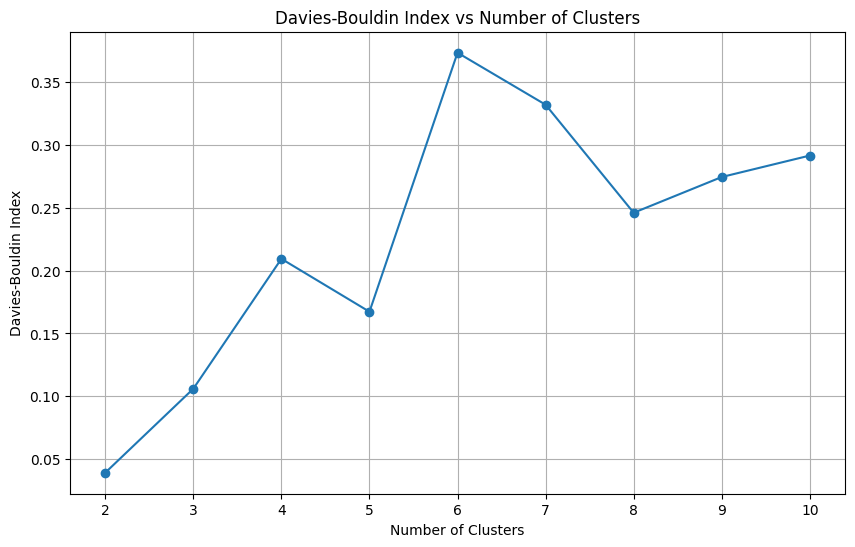

In [75]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

max_clusters = 10
min_clusters = 2

# Remove CustomerID column and prepare features for clustering
features = user_profiles.drop('CustomerID', axis=1).values

# Scale the features
max_clusters = 10
db_scores = []

for n_clusters in range(min_clusters, max_clusters + 1):
    # Use 'precomputed' affinity and 'complete' linkage
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = clustering.fit_predict(1 - similarity_matrix)
    score = davies_bouldin_score(1 - similarity_matrix, labels)  # Use 1 - similarity matrix for DB score
    db_scores.append(score)

# Find optimal number of clusters
optimal_clusters = np.argmin(db_scores) + min_clusters # Add 4 because we started from 4 clusters

# Plot Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)
plt.show()

In [76]:
print("Minimum DB index: ", np.min(db_scores))
print("Optimal No. of clusters: ", optimal_clusters)

Minimum DB index:  0.039102555579747594
Optimal No. of clusters:  2


In [77]:
# Perform clustering with optimal number of clusters
final_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, metric='precomputed', linkage='average')
cluster_labels = final_clustering.fit_predict(1 - similarity_matrix)

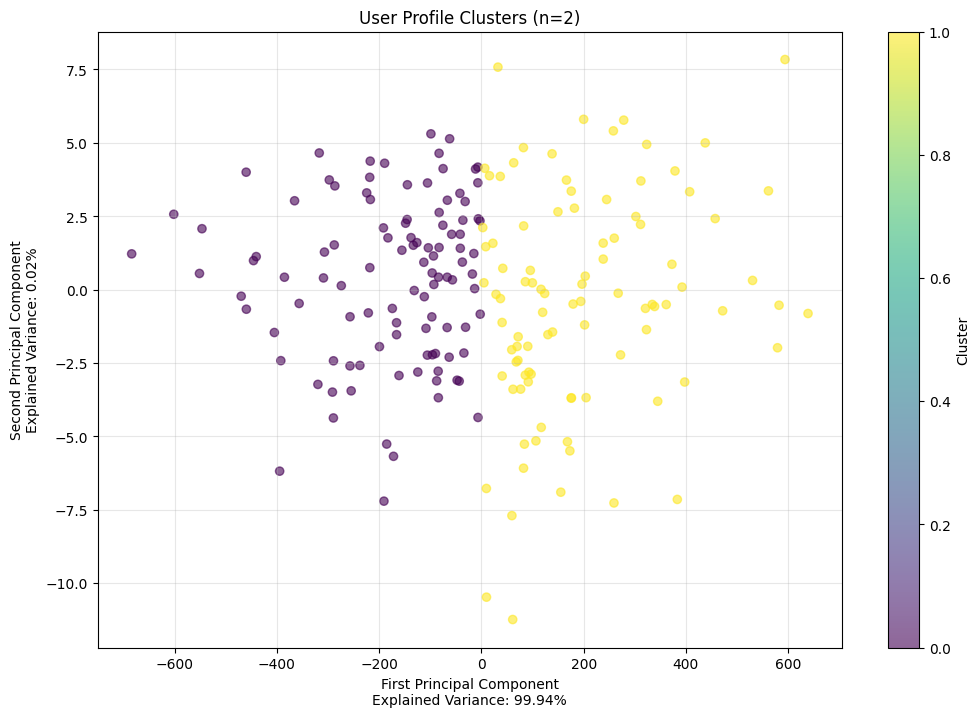

In [78]:
# Perform PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Create scatter plot of clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                      c=cluster_labels, cmap='viridis',
                      alpha=0.6)
plt.xlabel(f'First Principal Component\nExplained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'Second Principal Component\nExplained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.title(f'User Profile Clusters (n={optimal_clusters})')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [79]:
# Add cluster labels to the original dataframe
user_profiles['Cluster'] = cluster_labels

# Calculate and print cluster statistics
print("\nCluster Statistics:")
print("-" * 50)
cluster_stats = user_profiles.groupby('Cluster').agg({
    'avg_transaction_value': ['mean', 'count'],
    **{col: 'mean' for col in user_profiles.columns if col.startswith('Region_') or col not in ['CustomerID', 'Cluster', 'avg_transaction_value']}
}).round(2)
print(cluster_stats)


Cluster Statistics:
--------------------------------------------------
        avg_transaction_value       Region_Asia Region_Europe  \
                         mean count        mean          mean   
Cluster                                                         
0                      505.63   105        0.22          0.24   
1                      881.45    95        0.23          0.26   

        Region_North America Region_South America Books Clothing Electronics  \
                        mean                 mean  mean     mean        mean   
Cluster                                                                        
0                       0.27                 0.28  2.78     2.50        2.69   
1                       0.19                 0.32  4.09     3.44        3.63   

        Home Decor  
              mean  
Cluster             
0             3.20  
1             3.19  


In [81]:
cluster_avg_similarities = {}
cluster_min_similarities = {}

for cluster in user_profiles['Cluster'].unique():
    # Get indices of users in the current cluster
    cluster_indices = user_profiles[user_profiles['Cluster'] == cluster].index

    # Get the subset of the similarity matrix for users in the cluster
    cluster_similarity_matrix = similarity_matrix[cluster_indices.to_numpy()][:, cluster_indices.to_numpy()]

    # Exclude self-similarity (diagonal elements)
    cluster_similarity_matrix = cluster_similarity_matrix[np.triu_indices(len(cluster_indices), k=1)]

    # Calculate average and minimum similarity
    cluster_avg_similarities[cluster] = np.mean(cluster_similarity_matrix)
    cluster_min_similarities[cluster] = np.min(cluster_similarity_matrix)

# Print results
print("\nIntra-Cluster Average Similarities (Mean-Centered Cosine):")
for cluster, avg_similarity in cluster_avg_similarities.items():
    print(f"Cluster {cluster}: {avg_similarity:.4f}")

print("\nIntra-Cluster Minimum Similarities (Mean-Centered Cosine):")
for cluster, min_similarity in cluster_min_similarities.items():
    print(f"Cluster {cluster}: {min_similarity:.4f}")


Intra-Cluster Average Similarities (Mean-Centered Cosine):
Cluster 0: 0.9560
Cluster 1: 0.9562

Intra-Cluster Minimum Similarities (Mean-Centered Cosine):
Cluster 0: -0.0381
Cluster 1: -0.0707
